## Functions

In [73]:
# %matplotlib inline

import numpy as np
from skimage import transform, io, filters
import skimage.util
import os
import glob
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, BatchNormalization
from keras import layers
import tensorflow as tf
import time
from keras import backend as K
# from tensorflow.keras import layers

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


def get_unet_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

def path_planning_model():
    x = Input(shape=(None, None, 1))

    net = Conv2D(filters=64, kernel_size=[3, 3], strides=[1, 1], padding="same", kernel_initializer='orthogonal', activation='relu')(x)
    net = BatchNormalization()(net)
    for i in range(19):
        net = Conv2D(filters=64, kernel_size=[3, 3], strides=[1, 1], padding="same", kernel_initializer='orthogonal', activation='relu')(net)
        net = BatchNormalization()(net)
        
    net = Conv2D(filters=1, kernel_size=[3, 3], strides=[1, 1], padding="same", kernel_initializer='orthogonal', activation='sigmoid')(net)
    net = BatchNormalization()(net)
    net = Conv2D(filters=1, kernel_size=[3, 3], strides=[1, 1], padding="same", kernel_initializer='orthogonal', activation='sigmoid')(net)
    net = BatchNormalization()(net)	
    net = Dropout(0.10)(net)
    # Define the model
    model = keras.Model(inputs=x, outputs=net)
    return model

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred.flatten(), 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    b = plt.plot(t['pred'].tolist(),label='prediction',color = 'orange')
    a = plt.plot(t['y'].tolist(),label='expected',color = 'blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()

## Train Data

In [74]:

root_dir = ".."
data_dir = os.path.join(root_dir,"data")
mazes_dir = os.path.join(data_dir, "mazes" )
train_csv_path = os.path.join(mazes_dir,"mazes_train.csv")
test_csv_path = os.path.join(mazes_dir,"mazes_test.csv")
valid_csv_path = os.path.join(mazes_dir,"mazes_validation.csv")
train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)
valid_data = pd.read_csv(valid_csv_path)

# X - map image file
# Y - Path
# x_train y_train
# x_train,y_train = to_xy(train_data,'Path')
# y_train = train_data['Path']
# print(f"Shape of y_train {y_train.shape}")
# print(train_data.dtypes)
# print(train_data['Path'][0])

x_train_imgs = glob.glob(os.path.join(mazes_dir, "train/*.png"))
x_imgs_train = []
x_labels_train = []
for img_path in x_train_imgs:
    img = io.imread(img_path, as_gray=True)
    x_imgs_train.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_train.append(img_name)
print(f"# of images: {len(x_imgs_train)}")
X_train = np.array(x_imgs_train, dtype='float32')
X_train/=255
print(f"{X_train.ndim}")
print("X_train")
print(f"{X_train.shape}")
print(f"{X_train.dtype.names}")
print(f"{X_train[0]}")

y_train_imgs = glob.glob(os.path.join(mazes_dir, "train_path/*.png"))
y_imgs_train = []
y_labels_train = []
for img_path in y_train_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_train.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_train.append(img_name)
print(f"# of images: {len(y_imgs_train)}")
y_train = np.array(y_imgs_train, dtype='float32')
y_train/=255
print(f"{y_train.ndim}")
print("y_train")
print(f"{y_train.shape}")
print(f"{y_train.dtype.names}")
print(f"{y_train[0]}")

# x_test y_test
# x_test,y_test = to_xy(test_data,'Path')
# y_test = test_data['Path']
# print(f"Shape of y_train {y_test.shape}")
# print(test_data.dtypes)
# print(test_data['Path'][0])

# of images: 800
3
X_train
(800, 32, 32)
None
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
# of images: 800
3
y_train
(800, 32, 32)
None
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 0. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]]


## Validation Data

In [75]:
x_valid_imgs = glob.glob(os.path.join(mazes_dir, "validation/*.png"))
x_imgs_valid = []
x_labels_valid = []
for img_path in x_valid_imgs:
    img = io.imread(img_path, as_gray=True)
    x_imgs_valid.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    x_labels_valid.append(img_name)
print(f"# of images: {len(x_imgs_valid)}")
X_valid = np.array(x_imgs_valid, dtype='float32')
X_valid/=255
print(f"{X_valid.ndim}")
print("X_valid")
print(f"{X_valid.shape}")
print(f"{X_valid.dtype.names}")
print(f"{X_valid[0]}")

y_valid_imgs = glob.glob(os.path.join(mazes_dir, "validation_path/*.png"))
y_imgs_valid = []
y_labels_valid = []
for img_path in y_valid_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_valid.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_valid.append(img_name)
print(f"# of images: {len(y_imgs_valid)}")
y_valid = np.array(y_imgs_valid, dtype='float32')
y_valid/=255
print(f"{y_valid.ndim}")
print("y_valid")
print(f"{y_valid.shape}")
print(f"{y_valid.dtype.names}")
print(f"{y_valid[0]}")

# of images: 100
3
X_valid
(100, 32, 32)
None
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
# of images: 100
3
y_valid
(100, 32, 32)
None
[[1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 0. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]]


## Test Data

In [76]:
x_test_imgs = glob.glob(os.path.join(mazes_dir, "test/*.png"))
imgs_test = []
labels_test = []
for img_path in x_test_imgs:
    img = io.imread(img_path, as_gray=True)
    imgs_test.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    labels_test.append(img_name)
print(f"# of images: {len(imgs_test)}")
X_test = np.array(imgs_test, dtype='float32')
X_test/=255
# X_test = np.array(imgs_test)
print(f"{X_test.ndim}")
print("X_test")
print(f"{X_test.shape}")
print(f"{X_test.dtype.names}")
print(f"{X_test[0]}")

y_test_imgs = glob.glob(os.path.join(mazes_dir, "test_path/*.png"))
y_imgs_test = []
y_labels_test = []
for img_path in y_test_imgs:
    img = io.imread(img_path, as_gray=True)
    y_imgs_test.append(img)
    img_name = img_path.split('/')[-1]
    img_name = img_name.split('.')[0]
    y_labels_test.append(img_name)
print(f"# of images: {len(y_imgs_test)}")
y_test = np.array(y_imgs_test, dtype='float32')
y_test/=255
print(f"{y_test.ndim}")
print("y_test")
print(f"{y_test.shape}")
print(f"{y_test.dtype.names}")
print(f"{y_test[0]}")

# of images: 100
3
X_test
(100, 32, 32)
None
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
# of images: 100
3
y_test
(100, 32, 32)
None
[[1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 0. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]]


In [77]:

# input_shape = (32, 32, 1)
img_rows, img_cols = 32, 32
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_valid = X_valid.reshape(X_valid.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    y_train = y_train.reshape(y_train.shape[0], 1, img_rows, img_cols)
    y_valid = y_valid.reshape(y_valid.shape[0], 1, img_rows, img_cols)
    y_test = y_test.reshape(y_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    y_train = y_train.reshape(y_train.shape[0], img_rows, img_cols, 1)
    y_valid = y_valid.reshape(y_valid.shape[0], img_rows, img_cols, 1)
    y_test = y_test.reshape(y_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

## Model

In [78]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
# model = get_unet_model((img_rows, img_cols), num_classes)
model = path_planning_model()
model.summary()


# print("X_train")
# print(f"{X_train.ndim}")
# print(f"{X_train.shape}")
# print(f"{X_train.dtype.names}")
# # print(f"{X_train[0]}")

# print("X_test")
# print(f"{X_test.ndim}")
# print(f"{X_test.shape}")
# print(f"{X_test.dtype.names}")
# print(f"{X_test[0]}")
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# model.compile ( optimizer='adam',
#                 loss='mse',
#                 metrics=['accuracy'])
model.compile ( optimizer=adam,
                loss='mse',
                metrics=['accuracy'])
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                 activation='relu',
#                 input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(input_shape, activation='softmax'))
# model.compile(loss=keras.losses.categorical_crossentropy,
#             optimizer=keras.optimizers.Adadelta(),
#             metrics=['accuracy'])
# print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    640       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 64)    256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, None, None, 64)    256       
__________

In [79]:
batch_size = 128
num_classes = 1
# epochs = 12
epochs = 100

# --- Training
start_time = time.time()

model.fit(X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

model.save("path-planning.h5")

Train on 800 samples, validate on 100 samples
Epoch 1/100
 - 5s - loss: 1.9827 - acc: 0.2517 - val_loss: 6.6878 - val_acc: 0.0264
Epoch 2/100
 - 1s - loss: 1.8621 - acc: 0.3031 - val_loss: 6.4356 - val_acc: 0.0532
Epoch 3/100
 - 1s - loss: 1.7665 - acc: 0.2855 - val_loss: 5.2241 - val_acc: 0.1200
Epoch 4/100
 - 1s - loss: 1.6770 - acc: 0.2440 - val_loss: 2.9536 - val_acc: 0.1900
Epoch 5/100
 - 1s - loss: 1.6111 - acc: 0.2147 - val_loss: 1.4466 - val_acc: 0.3093
Epoch 6/100
 - 1s - loss: 1.5520 - acc: 0.2062 - val_loss: 1.0320 - val_acc: 0.3103
Epoch 7/100
 - 1s - loss: 1.4806 - acc: 0.1870 - val_loss: 1.1997 - val_acc: 0.1635
Epoch 8/100
 - 1s - loss: 1.4135 - acc: 0.2024 - val_loss: 1.2987 - val_acc: 0.2538
Epoch 9/100
 - 1s - loss: 1.3116 - acc: 0.1709 - val_loss: 2.5653 - val_acc: 0.1819
Epoch 10/100
 - 1s - loss: 1.1002 - acc: 0.1804 - val_loss: 5.0108 - val_acc: 0.1343
Epoch 11/100
 - 1s - loss: 0.9820 - acc: 0.1208 - val_loss: 4.5083 - val_acc: 0.1716
Epoch 12/100
 - 1s - loss: 0

Predict image
[[[ 0.58358574]
  [ 0.5938587 ]
  [ 0.5865793 ]
  ...
  [ 0.5434952 ]
  [ 0.5725994 ]
  [-0.1084528 ]]

 [[ 0.56992626]
  [ 0.5819626 ]
  [ 0.58943844]
  ...
  [ 0.7019253 ]
  [ 0.6001959 ]
  [-0.33398342]]

 [[ 0.5932646 ]
  [ 0.60709286]
  [ 0.62771606]
  ...
  [ 0.57866764]
  [ 0.17043114]
  [ 0.04445744]]

 ...

 [[ 0.6921387 ]
  [ 0.71777725]
  [-0.22469807]
  ...
  [ 0.61697674]
  [ 0.5965061 ]
  [ 0.6314001 ]]

 [[ 0.7519131 ]
  [-0.02477741]
  [ 0.7138901 ]
  ...
  [ 0.60735226]
  [ 0.6014061 ]
  [ 0.6167917 ]]

 [[-0.04378033]
  [ 0.7550783 ]
  [ 0.6464853 ]
  ...
  [ 0.6037054 ]
  [ 0.5734196 ]
  [ 0.57850933]]]


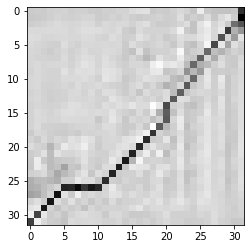

In [80]:
pred = model.predict(X_test)
print("Predict image")
print(pred[0])
plt.imshow(pred[0], cmap='gray', interpolation='nearest')


In [81]:
# Save prediction images
output_dir = os.path.join(root_dir,"output")
mazes_output_dir = os.path.join(output_dir,"mazes")
for i,p in enumerate(pred):
    img_name = labels_test[i]
    # print(img_name)
    io.imsave(os.path.join(mazes_output_dir,img_name+".png"), p)


Lossy conversion from float32 to uint8. Range [-0.3339834213256836, 0.8225193023681641]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.34578990936279297, 0.8206596374511719]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.30275630950927734, 0.8444643020629883]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.2870597839355469, 0.8028335571289062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.3375234603881836, 0.8413162231445312]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.23674297332763672, 0.8175268173217773]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.28694915771484375, 0.79

961


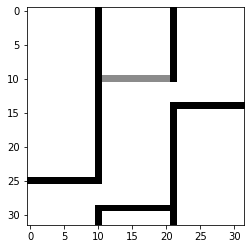

In [82]:
print(labels_test[0])
plt.imshow(X_test[0], cmap='gray', interpolation='nearest')


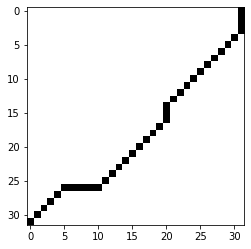

In [83]:
plt.imshow(y_test[0], cmap='gray', interpolation='nearest')

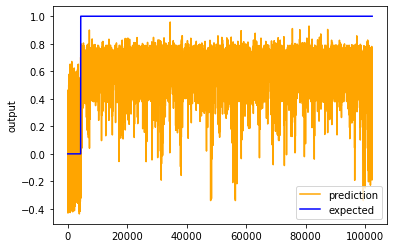

In [84]:
chart_regression(pred,y_test)


[-0.04378033]


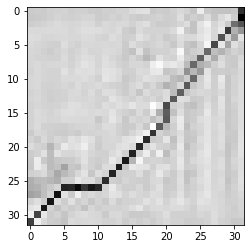

In [85]:
# pred[0]*=255
plt.imshow((pred[0]), cmap='gray', interpolation='nearest')
# plt.imshow((pred[0]), cmap='binary')
print(pred[0][31,0])